In [1]:
import torch
from PIL import Image
from torchvision import transforms
import os
import torch.nn.functional as F

from tqdm import tqdm
import torchvision
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset, RandomSampler

import warnings
warnings.filterwarnings('ignore')


import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

import random
import shutil

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import skimage.io as io

dinov2_vits14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')
dinov2_vits14_lc_batch9=dinov2_vits14_lc
dinov2_vits14_lc_batch9.linear_head=nn.Linear(1920,4)

Using cache found in /Users/xiatian2/.cache/torch/hub/facebookresearch_dinov2_main


In [3]:
samples_dir='/Users/xiatian2/VIT/batch9/raw'
file_list=[x for x in os.listdir(samples_dir) if ".tiff" in x]
train_list=random.sample(file_list, 3100)
for file_name in train_list:
    os.rename(os.path.join(samples_dir,file_name),os.path.join(samples_dir,'train',file_name))

In [2]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [2]:
dinov2_vits14_lc

Using cache found in /Users/xiatian2/.cache/torch/hub/facebookresearch_dinov2_main


_LinearClassifierWrapper(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=Fals

In [43]:
from torch.utils.data import Dataset
import json
class ImageNetKaggle(Dataset):
    def __init__(self, root, split, transform=None):
        self.samples = []
        self.targets = []
        self.transform = transform
        self.syn_to_class = {}
        with open(os.path.join(root, "imagenet_class_index.json"), "rb") as f:
                    json_file = json.load(f)
                    for class_id, v in json_file.items():
                        self.syn_to_class[v[0]] = int(class_id)
        with open(os.path.join(root, "ILSVRC2012_val_labels.json"), "rb") as f:
                    self.val_to_syn = json.load(f)
        samples_dir = os.path.join(root, split)
        for entry in os.listdir(samples_dir):
            if split == "train":
                syn_id = entry
                target = self.syn_to_class[syn_id]
                syn_folder = os.path.join(samples_dir, syn_id)
                for sample in os.listdir(syn_folder):
                    sample_path = os.path.join(syn_folder, sample)
                    self.samples.append(sample_path)
                    self.targets.append(target)
            elif split == "val":
                syn_id = self.val_to_syn[entry]
                target = self.syn_to_class[syn_id]
                sample_path = os.path.join(samples_dir, entry)
                self.samples.append(sample_path)
                self.targets.append(target)
    def __len__(self):
            return len(self.samples)
    def __getitem__(self, idx):
            x = Image.open(self.samples[idx]).convert("RGB")
            if self.transform:
                x = self.transform(x)
            return x, self.targets[idx]

In [44]:
model = dinov2_vits14_lc 
model.eval() 
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
val_transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
val_data = ImageNetKaggle('/Users/xiatian2/VIT/imagenet1k', "val", val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


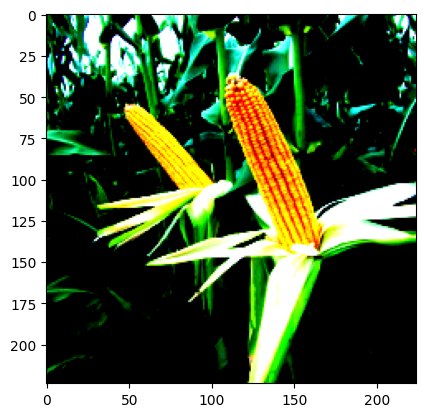

In [58]:
x_before = Image.open('/Users/xiatian2/VIT/imagenet1k/val/ILSVRC2012_val_00019877.JPEG').convert("RGB")
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
val_transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
x_after = val_transform(x_before)
plt.imshow(x_after.permute(1, 2, 0))
plt.show()


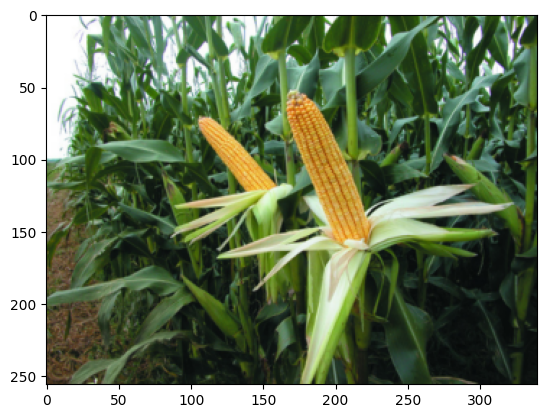

In [63]:
val_transform = transforms.Compose(
            [
                transforms.Resize(256)])
x_after = val_transform(x_before)
plt.imshow(x_after)

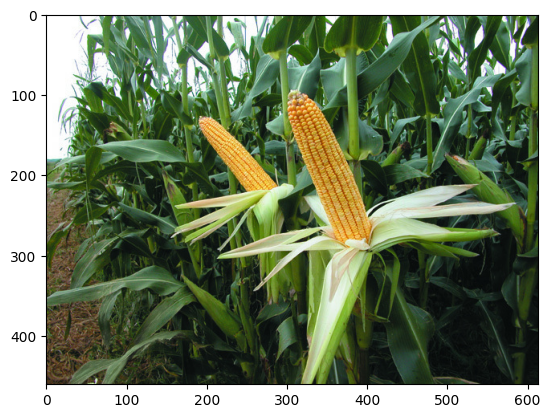

In [18]:
plt.imshow(x_before)

In [17]:
# how pil deal with multi-channel image? skimage.io
import skimage.io as io
x_before = io.imread('/Users/xiatian2/VIT/imagenet1k/WellA1_PointA1_0875_ChannelCellmask2_nIR,AF647,PhalloAF568,ZO1-AF488,DAPI_Seq0875.ome.tiff')
mean = (0.485, 0.456, 0.406 , 0.456, 0.456)
std = (0.229, 0.224, 0.225,0.224,0.224)
val_transform = transforms.Compose(
            [   
                transforms.ToPILImage(),
                transforms.RandomCrop(size=(421,484)),
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
x_after = val_transform(x_before)
plt.imshow(x_after.permute(1, 2, 0))
plt.show()

ValueError: pic should not have > 4 channels. Got 1600 channels.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


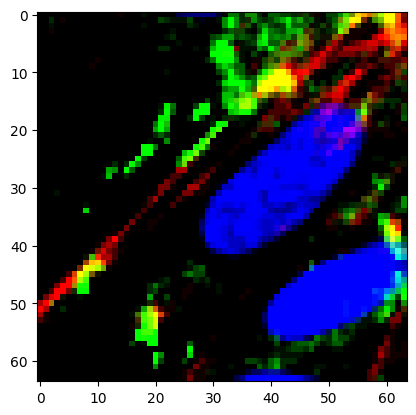

In [28]:
file_path='/Users/xiatian2/VIT/batch9/train/raw/WellA2_PointA2_0241_ChannelPhalloAF750,ZO1-AF488,DAPI_Seq1266.ome.tiff'
x_before = io.imread(file_path)
x_before=Image.fromarray((x_before / 256).astype('uint8')).convert('RGB')

mean = (0.03, 0.08, 0.02) 
std = (0.02, 0.04, 0.04)
#mean = (-0.1, -0.1, -0.1)
#std = (0.6, 0.6, 0.6)

random.seed(100)
torch.manual_seed(100)
val_transform = transforms.Compose(
            [   
                transforms.RandomCrop(size=(64,64)),
                #transforms.Resize(256),
                #transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
x_after = val_transform(x_before)
plt.imshow(x_after.permute(1, 2, 0))
plt.show()

In [19]:
file_path='/Users/xiatian2/VIT/batch9/train/raw/WellA2_PointA2_0241_ChannelPhalloAF750,ZO1-AF488,DAPI_Seq1266.ome.tiff'
#file_path='/Users/xiatian2/VIT/imagenet1k/val/ILSVRC2012_val_00019877.JPEG'
x_before = (io.imread(file_path)/256).astype('uint8')
print(np.mean(x_before,axis=(0,1))/256)
print(np.std(x_before,axis=(0,1))/256)

[0.03313066 0.08637336 0.01969597]
[0.01987218 0.04165211 0.03504103]


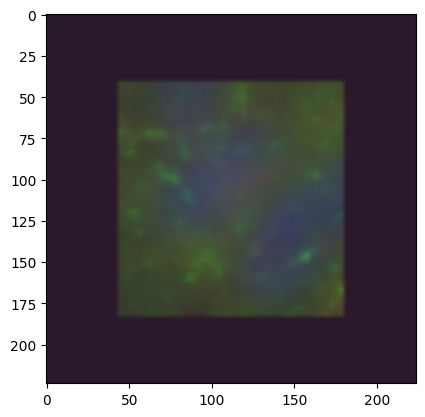

In [22]:
df_cell=pd.read_feather('/Users/xiatian2/VIT/Cells.feather')
file_path='/Users/xiatian2/VIT/batch9/train/raw/WellA2_PointA2_0241_ChannelPhalloAF750,ZO1-AF488,DAPI_Seq1266.ome.tiff'
x_before = io.imread(file_path)
x_before=Image.fromarray((x_before / 256).astype('uint8')).convert('RGB')
cell_index=random.choice(df_cell[df_cell.FileName_OrigDAPI==file_path.split('/')[-1]].index)
            
x_before=x_before.crop((df_cell.loc[cell_index,'AreaShape_BoundingBoxMinimum_X'],df_cell.loc[cell_index,'AreaShape_BoundingBoxMinimum_Y'],df_cell.loc[cell_index,'AreaShape_BoundingBoxMaximum_X'],df_cell.loc[cell_index,'AreaShape_BoundingBoxMaximum_Y']))

mean = (-0.1, -0.1, -0.1)
std = (0.6, 0.6, 0.6)
val_transform = transforms.Compose(
            [   
                transforms.Pad(padding=20),
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
x_after = val_transform(x_before)
plt.imshow(x_after.permute(1, 2, 0))
plt.show()

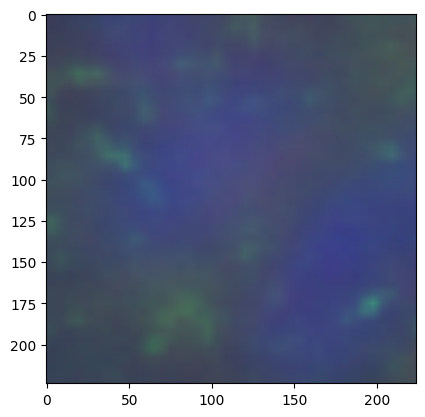

In [26]:
mean = (-0.1, -0.1, -0.2)
std = (0.6, 1, 0.6)
val_transform = transforms.Compose(
            [   
                transforms.Pad(padding=0),
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
x_after = val_transform(x_before)
plt.imshow(x_after.permute(1, 2, 0))
plt.show()

In [30]:
df_cell[df_cell.FileName_OrigDAPI==file_path.split('/')[-1]].index

Int64Index([1580345, 1580346, 1580347, 1580348, 1580349, 1580350, 1580351,
            1580352, 1580353, 1580354,
            ...
            1581238, 1581239, 1581240, 1581241, 1581242, 1581243, 1581244,
            1581245, 1581246, 1581247],
           dtype='int64', length=903)

In [40]:
transform = transforms.Compose([
              transforms.ToTensor()
            ])
x_mid=transform(x_before)
x_mid.permute(1, 2, 0)[:,:,0]

tensor([[0.0078, 0.0078, 0.0118,  ..., 0.0157, 0.0078, 0.0118],
        [0.0078, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
        [0.0078, 0.0118, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
        ...,
        [0.0431, 0.0471, 0.0471,  ..., 0.0235, 0.0196, 0.0275],
        [0.0392, 0.0431, 0.0471,  ..., 0.0196, 0.0196, 0.0235],
        [0.0392, 0.0392, 0.0431,  ..., 0.0157, 0.0196, 0.0196]])

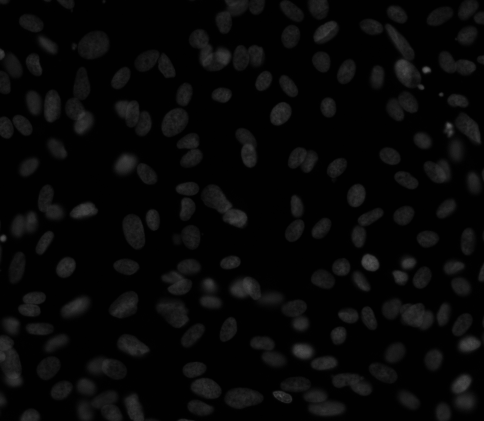

In [6]:
transforms.RandomCrop(size=(421,484))(x_before)

In [9]:
import PIL
mean_all=[]
std_all=[]
train_data=AMDEMTBatch9('/Users/xiatian2/VIT/batch9','train',transform=None)
for x, y in train_data:
    mean_all.append(list(PIL.ImageStat.Stat(x).mean))
    std_all.append(list(PIL.ImageStat.Stat(x).stddev))
print(np.mean(mean_all))
print(np.std(std_all))

254.5963101926814
3.243311478986543


In [75]:
print(np.std(width))
print(np.std(height))

125.00263037232456
120.57807469021887


Text(0.5, 1.0, 'width')

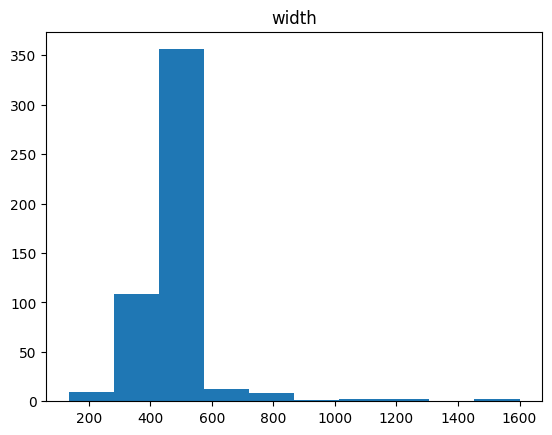

In [74]:
plt.hist(width)
plt.title('width')

In [48]:



'''
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data), (batch_size,))
    x = torch.stack([data.__getitem__(i) for i in ix])
    y = torch.stack([data.targets[i] for i in ix])
    return x, y
batch_size=12
x, y = get_batch('val')
'''




In [50]:
dataloader = DataLoader(
            val_data,
            batch_size=4, # may need to reduce this depending on your GPU 
            shuffle=True
        )

correct = 0
total = 0
with torch.no_grad():
    for x, y in tqdm(dataloader):
        y_pred = model(x)
        correct += (y_pred.argmax(axis=1) == y).sum().item()
        total += len(y)
        
print(correct / total)

100%|██████████| 12500/12500 [31:58<00:00,  6.52it/s] 

0.81332


In [37]:
from torch.utils.data import Dataset
import json
tar_dic={'WellA1':0,'WellA2':1,'WellA3':2,'WellB1':3}
df_cell=pd.read_feather('/Users/xiatian2/VIT/Cells.feather')
class AMDEMTBatch9(Dataset):
    def __init__(self, root, split, transform=None):
        self.samples = []
        self.targets = []
        self.transform = transform
        samples_dir = os.path.join(root, 'raw',split)
        for entry in os.listdir(samples_dir):
            if entry.endswith('.tiff'):
                if split == "val":
                    sample_path = os.path.join(samples_dir, entry)
                    self.samples.append(sample_path)
                    self.targets.append(tar_dic[entry.split('_')[0]])
                elif split == "train":
                    sample_path = os.path.join(samples_dir, entry)
                    self.samples.append(sample_path)
                    self.targets.append(tar_dic[entry.split('_')[0]])
    def __len__(self):
            return len(self.samples)
    def __getitem__(self, idx):
            x = io.imread(self.samples[idx])
            x = Image.fromarray((x / 256).astype('uint8')).convert('RGB')#change 16 bit image to 8 bit
            if len(df_cell[df_cell.FileName_OrigDAPI==self.samples[idx].split('/')[-1]].index)>=1:
                cell_index=random.choice(df_cell[df_cell.FileName_OrigDAPI==self.samples[idx].split('/')[-1]].index)
                
                x = x.crop((df_cell.loc[cell_index,'AreaShape_BoundingBoxMinimum_X'],df_cell.loc[cell_index,'AreaShape_BoundingBoxMinimum_Y'],
                    df_cell.loc[cell_index,'AreaShape_BoundingBoxMaximum_X'],df_cell.loc[cell_index,'AreaShape_BoundingBoxMaximum_Y']))
            else: 
                corner = random.randrange(1500)
                x = x.crop((corner,corner,corner+32,corner+32))
            if self.transform:
                x = self.transform(x)
            return x, self.targets[idx]
    
model = dinov2_vits14_lc_batch9

mean = (-0.1, -0.1, -0.1)
std = (0.6, 0.6, 0.6)

data_transforms = {
'train': transforms.Compose(
            [   
                transforms.Pad(padding=0),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        ),
'val': transforms.Compose(
            [   
                transforms.Pad(padding=0),
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )}
image_datasets = {x: AMDEMTBatch9('/Users/xiatian2/VIT/batch9', x, data_transforms[x])
                  for x in ['train', 'val']}

sampler = {x: RandomSampler(image_datasets[x], replacement=True, num_samples=400)
              for x in ['train', 'val']}
dataloaders = {x: DataLoader(dataset=image_datasets[x], sampler=sampler[x],batch_size=8,drop_last=True)
              for x in ['train', 'val']}


correct = 0
total = 0

'''
with torch.no_grad():
    for x, y in tqdm(dataloaders['val']):
        y_pred = model(x)
        print ((y_pred.argmax(axis=1) == y).sum().item())
        correct += (y_pred.argmax(axis=1) == y).sum().item()
        total += len(y)
        
print(correct / total)
'''

: 

In [ ]:
#only optimize linear head
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler= optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

epochs = 10 #50 does not increase much
model=dinov2_vits14_lc_batch9
'''
for param in model.parameters():
   param.requires_grad = False
num_ftrs = model.linear_head.in_features
model.linear_head = nn.Linear(num_ftrs, 4)
'''
#model.load_state_dict(torch.load('10epoch_fewshot_dinov2_vits14_lc_accp35.pth'))
best_acc=0.0
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs - 1}')
    print('-' * 10)
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode
        
        running_loss,running_corrects,total=0.0,0.0,0.0
        for x, y in dataloaders[phase]:
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                output = model(x)
                _, preds = torch.max(output, 1)
                loss = criterion(output, y)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item() * x.size(0)
            running_corrects += torch.sum(preds == y.data)
            total += len(y)
        #if phase == 'train':    
            #scheduler.step()
        #print(total)
        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), '10epoch_fewshot_dinov2_vits14_lc_batch9.pth')

print(f'Best val Acc: {best_acc:4f}')

Epoch 0/9
----------
train Loss: 1.5389 Acc: 0.2660
val Loss: 1.6265 Acc: 0.2390
Epoch 1/9
----------
train Loss: 1.4258 Acc: 0.2980
val Loss: 1.4001 Acc: 0.2620
Epoch 2/9
----------
train Loss: 1.3992 Acc: 0.2410
val Loss: 1.3994 Acc: 0.2460
Epoch 3/9
----------
train Loss: 1.4044 Acc: 0.2710
val Loss: 1.3865 Acc: 0.2630
Epoch 4/9
----------
train Loss: 1.3798 Acc: 0.2920
val Loss: 1.3775 Acc: 0.2880
Epoch 5/9
----------
train Loss: 1.3789 Acc: 0.3020
val Loss: 1.3858 Acc: 0.2150
Epoch 6/9
----------
train Loss: 1.3775 Acc: 0.2590
val Loss: 1.3778 Acc: 0.2950
Epoch 7/9
----------
train Loss: 1.3758 Acc: 0.3120
val Loss: 1.3740 Acc: 0.2630
Epoch 8/9
----------
train Loss: 1.3789 Acc: 0.2570


KeyboardInterrupt: 

In [36]:
dinov2_vitg14_reg_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg_lc')
dinov2_vitg14_reg_lc


Using cache found in /Users/xiatian2/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_reg4_pretrain.pth" to /Users/xiatian2/.cache/torch/hub/checkpoints/dinov2_vitg14_reg4_pretrain.pth
100%|██████████| 4.23G/4.23G [06:57<00:00, 10.9MB/s]
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_reg4_linear4_head.pth" to /Users/xiatian2/.cache/torch/hub/checkpoints/dinov2_vitg14_reg4_linear4_head.pth
100%|██████████| 29.3M/29.3M [00:03<00:00, 8.32MB/s]


_LinearClassifierWrapper(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-39): 40 x NestedTensorBlock(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1536, out_features=4608, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1536, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (mlp): SwiGLUFFNFused(
          (w12): Linear(in_features=1536, out_features=8192, bias=True)
          (w3): Linear(in_features=4096, out_features=1536, bias=True)
        )
        (ls2): LayerScale()
        (drop_path2): Identity(

In [35]:
dinov2_vits14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')
dinov2_vits14_lc

Using cache found in /Users/xiatian2/.cache/torch/hub/facebookresearch_dinov2_main


_LinearClassifierWrapper(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=Fals

In [10]:
from torchvision.models import swin_v2_s, Swin_V2_S_Weights

model_name = 'swin_s_v2'
weights = Swin_V2_S_Weights.IMAGENET1K_V1
model = swin_v2_s(weights=weights)
transform = weights.transforms()

print(transform)

Downloading: "https://download.pytorch.org/models/swin_v2_s-637d8ceb.pth" to /Users/xiatian2/.cache/torch/hub/checkpoints/swin_v2_s-637d8ceb.pth
100%|██████████| 191M/191M [00:17<00:00, 11.5MB/s] 


ImageClassification(
    crop_size=[256]
    resize_size=[260]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [33]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/xiatian2/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
Python(94859) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 44.7M/44.7M [00:02<00:00, 17.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
#way 0: problematic data not aranged by the class/image
#torch.io support read image good to know
# I need 
# 1 read image with either torch.io or PIL or imagenet settinig in pytroch 
# 2 get the label from path 
# 3 data load for batch processing 

class ImagenetClassDataset(Dataset):
    def __init__(self, path:str, class_id:int, transform):
        #assert path.split('/')[-1] == 'train'
        super().__init__()
        class_names = sorted(os.listdir(path))
        self.class_name = class_names[class_id]
        self.class_path = path + '/' + self.class_name
        
        self.img_names = sorted(os.listdir(self.class_path))
        self.transform = transform
    
    def __getitem__(self, idx):
        img_path = self.class_path + '/' + self.img_names[idx]
        image = read_image(img_path, ImageReadMode.RGB)
        return self.transform(image)
    
    def __len__(self):
        return len(self.img_names)

train_path = image_dir

num_classes = 1000
chunk_size = 200 # number of classes in one chunk

model = model.to(device)
model.eval()

for chunk_id in range(num_classes // chunk_size):
    subsets = []
    name_list = []
    for i in range(chunk_id * chunk_size, (chunk_id+1) * chunk_size):
        class_subset = ImagenetClassDataset(train_path, class_id=i, transform=transform)
        subsets.append(class_subset)
        name_list += class_subset.img_names

    name_list = [name.split('.')[0] for name in name_list] # remove JPEG extension
    subset = ConcatDataset(subsets)
    train_dataloader = DataLoader(subset, batch_size=100, shuffle=False, num_workers=4)
    train_probs = torch.empty((len(subset), 1000), dtype=torch.float32)

    with torch.no_grad():
        for i, images in tqdm(enumerate(train_dataloader)):
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            train_probs[i*100: i*100 + probs.size(0)] = probs.detach().cpu()

    output = {
        'probs': train_probs,
        'img_names': name_list
    }

    torch.save(output, f'{model_name}_train_{chunk_id}.pth')

NotADirectoryError: [Errno 20] Not a directory: '/Users/xiatian2/Downloads/val_images/ILSVRC2012_val_00000001_n01751748.JPEG'

In [ ]:
#way 1: Creation of dataset_array and true_classes
#only for getting the label from the last word
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array,array_to_img
dataset_array = []
true_classes = []
images_array = []
for train_class in tqdm(os.listdir(train_path)):
    i = 0
    for el in os.listdir(train_path + '/' + train_class):
        if i < 10:
            path = train_path + '/' + train_class + '/' + el
            image = load_img(path,target_size=(224,224,3))
            image_array = img_to_array(image).astype(np.uint8)
            images_array.append(image_array)
            true_class = class_mapping_dict[path.split('/')[-2]]
            true_classes.append(true_class)
            i+=1
        else:
            break
images_array = np.array(images_array)
true_classes = np.array(true_classes)
print('Preprocessing in progress')
#dataset_array = preprocess_input(images_array)
print('FINISH')

In [ ]:
#way 2

batch_size = 128

def select_random_samples(dataset_path, output_path, num_classes, samples_per_class):
    # Get a list of all classes in the dataset
    all_classes = os.listdir(dataset_path)

    # Randomly select a specified number of classes
    selected_classes = random.sample(all_classes, num_classes)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Copy a specified number of samples from each selected class to the output directory
    for class_label in selected_classes:
        class_path = os.path.join(dataset_path, class_label)
        output_class_path = os.path.join(output_path, class_label)

        # Create the output class directory
        os.makedirs(output_class_path, exist_ok=True)

        # Get a list of all images in the class
        all_images = os.listdir(class_path)

        # Randomly select a specified number of samples
        selected_samples = random.sample(all_images, samples_per_class)

        # Copy selected samples to the output class directory
        for sample in selected_samples:
            sample_path = os.path.join(class_path, sample)
            output_sample_path = os.path.join(output_class_path, sample)
            shutil.copyfile(sample_path, output_sample_path)

dataset_train = '/kaggle/input/tiny-imagenet-200-zip/tiny-imagenet-200/train'
temp_dir_tr = 'kaggle/temp/temp_dataset_tr'
os.makedirs(temp_dir_tr, exist_ok=True)

try:
    shutil.copytree(dataset_train, temp_dir_tr)
except FileExistsError:
    print('The directory already exists')


dataset_test = '/kaggle/input/tiny-imagenet-200-zip/tiny-imagenet-200/test'
temp_dir_ts = 'kaggle/temp/temp_dataset_ts'
os.makedirs(temp_dir_ts, exist_ok=True)

try:
    shutil.copytree(dataset_test, temp_dir_ts)
except FileExistsError:
    print('The directory already exists')

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.ImageNet(root= '/kaggle/input/tiny-imagenet-200-zip/tiny-imagenet-200/train', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.ImageNet(root= '/kaggle/input/tiny-imagenet-200-zip/tiny-imagenet-200/test', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

# /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train
# /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/test

# Sub-datasets::
# (10 - 10)       # (30 - 10)
# (10 - 100)      # (30 - 100)
# (10 - 300)      # (30 - 300)

#usage:
dataset_path = '/kaggle/input/tiny-imagenet-200-zip/tiny-imagenet-200/train'
output_path = '/kaggle/working/'
num_classes = 10
samples_per_class = 10

select_random_samples(dataset_path, output_path, num_classes, samples_per_class)




In [ ]:
class ResNet50CustomInput(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(ResNet50CustomInput, self).__init__()

        # Load the pre-trained ResNet-50 model without the final classification layer
        self.resnet = models.resnet50(pretrained=True)
        # Remove the original fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])

        # Modify the first convolution layer to accept smaller input
        self.resnet[0] = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Adaptive average pooling layer to adapt to different input sizes
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # New fully connected layer for your specific number of classes
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate the modified ResNet-50 model
num_classes = 10  # Adjust to your specific number of classes
input_channels = 3  # Adjust to match your input data channels

model = ResNet50CustomInput(num_classes, input_channels)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            test_loss += criterion(output, labels).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [ ]:
epochs = 10 #50
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)
    torch.save(model.state_dict(), 'cifar_resnet50_model.pth')
    print('model saved')

In [ ]:
loaded_net = ResNet50CustomInput(num_classes, input_channels)
checkpoint = torch.load('cifar_resnet50_model.pth')
loaded_net.load_state_dict(checkpoint)
loaded_net = loaded_net.to(device)'

In [ ]:
#way 3 downloaded NAFS script where is read images? 
def build_val_transform(size):
    return transforms.Compose([
        transforms.Resize(int(math.ceil(size / 0.875))),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])
    
val_data = datasets.ImageFolder(
        root=os.path.join(imagenet_data_path),
        transform=build_val_transform(224)
    )


val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,  
    shuffle = True,
    num_workers=4,  
    pin_memory=True,
    drop_last=False,
)

In [8]:
#way 4 hugging face way to load_dataset? token not generated.. weird
from datasets import load_dataset
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import img_to_array
import numpy as np
import tensorflow as tf

BATCH_SIZE = 32
INPUT_SHAPE = (224, 224, 3)

dataset_train = load_dataset('ILSVRC/imagenet-1k', split='val', streaming=False, token='<my_token>', trust_remote_code=True)

def train_image_generator():
    for example in dataset_train:
        # Load the image and resize it to the size expected by ResNet50
        img = img_to_array(example['image'])
        # Convert single-channel images to RGB
        if img.shape[2] == 1:
            img = np.dstack([img] * 3)
        elif img.shape[2] == 4:
            img = img[..., :3]
        img = tf.image.resize(img, INPUT_SHAPE[:2])
        img = preprocess_input(img)
        yield img

ds_train = tf.data.Dataset.from_generator(train_image_generator, output_signature=(
    tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32)))

ds_train = ds_train.batch(BATCH_SIZE)

model = ResNet50(weights='imagenet', include_top=True)

# predict batch-by-batch to avoid running out of memory
total_predicted = 0
total_correct = 0
for batch in ds_train:
    train_pred = model.predict_on_batch(batch)

    # keras model outputs are one-hot
    # compare to hugging face ground truth, which is categorical
    num_predicted = len(train_pred)
    num_correct = np.count_nonzero(np.argmax(train_pred, axis=1) == dataset_train[total_predicted : total_predicted + len(batch)]['label'])

    total_predicted += num_predicted
    total_correct += num_correct

print(f"Accuracy: {100.0 * total_correct / total_predicted:.2f}% from {total_predicted} samples")

DatasetNotFoundError: Dataset 'ILSVRC/imagenet-1k' doesn't exist on the Hub or cannot be accessed. If the dataset is private or gated, make sure to log in with `huggingface-cli login` or visit the dataset page at https://huggingface.co/datasets/ILSVRC/imagenet-1k to ask for access.

In [12]:
# vit model predict on one image 
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Predicted class: Egyptian cat


In [14]:
#mobilenet predict on one image
from urllib.request import urlopen
from PIL import Image
import timm
import torch

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('mobilenetv3_large_100.ra_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)

In [16]:
top5_class_indices

tensor([[967, 960, 968, 969, 928]])